In [1]:
%%writefile jb_geometry.py
import math
import numpy as np 

def rotateZ( theta ):
    rz = np.array( [ [ math.cos( theta ), - math.sin( theta ), 0, 0 ],
                           [ math.sin( theta ), math.cos( theta ), 0, 0 ],
                           [ 0, 0, 1, 0 ],
                           [ 0, 0, 0, 1 ] ] )
    return rz

def rotateY( theta ):
    ry = np.array( [ [ math.cos( theta ), 0, math.sin( theta ), 0 ],
                           [ 0, 1, 0, 0 ],
                           [ - math.sin( theta ), 0, math.cos( theta ), 0 ],
                           [ 0, 0, 0, 1 ] ] )
    return ry

def rotateX( theta ):
    rx = np.array( [ [ 1, 0, 0, 0 ],
                           [ 0, math.cos( theta ), - math.sin( theta ), 0 ],
                           [ 0, math.sin( theta ), math.cos( theta ), 0 ],
                           [ 0, 0, 0, 1 ] ] )
    return rx

def translate( dx, dy, dz ):
    t = np.array( [ [ 1, 0, 0, dx ],
                          [ 0, 1, 0, dy ],
                          [ 0, 0, 1, dz ],
                          [ 0, 0, 0, 1 ] ] )
    return t

def DHH( theta, d, a, alpha ):
    return rotateZ( theta ).dot( translate( 0, 0, d) ).dot( translate( a, 0, 0 ) ).dot( rotateX( alpha ) )

def plotCoordinateSystem( ax, length = 1.0, width = 1.0, A = None ):
    if ( A is None ):
        A = np.eye( 4 )
    xAxis = np.array( [ [ 0, 0, 0, 1], [ length, 0, 0, 1 ] ] ).T
    yAxis = np.array( [ [ 0, 0, 0, 1], [ 0, length, 0, 1 ] ] ).T
    zAxis = np.array( [ [ 0, 0, 0, 1], [ 0, 0, length, 1 ] ] ).T
    
    ax.plot( A.dot( xAxis )[0,:], A.dot( xAxis )[1,:], A.dot( xAxis )[2,:], 'r-', linewidth=width )
    ax.plot( A.dot( yAxis )[0,:], A.dot( yAxis )[1,:], A.dot( yAxis )[2,:], 'g-', linewidth=width )
    ax.plot( A.dot( zAxis )[0,:], A.dot( zAxis )[1,:], A.dot( zAxis )[2,:], 'b-', linewidth=width )

def drawLink(ax, A1, A2, width=1 ):
    x1 = A1.dot( np.array( [ 0, 0, 0, 1 ] ).T )
    x2 = A2.dot( np.array( [ 0, 0, 0, 1 ] ).T )
    c = np.vstack( (x1, x2 ) ).T
    print('x1', x1, 'x2', x2, 'c', c)
    ax.plot( c[0,:], c[1,:], c[2,:], color='#50303030', linewidth=width )

Writing jb_geometry.py


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import jb_geometry as jbg

In [3]:

LEFT_ANKLE, RIGHT_ANKLE, LEFT_CALF, RIGHT_CALF, LEFT_THIGH, RIGHT_THIGH, TORSO, LEFT_LARM, RIGHT_LARM, LEFT_UARM, RIGHT_RARM, HEAD = range( 12 )

robotLinks = [ 0.1, 0.1, 0.12, 0.12, 0.092, 0.092, 0.08, 0.13, 0.13, 0.085, 0.085, 0.06 ]   # length of link in m (foot, calf, thigh, torso, lower arm, upper arm, head )
robotMasses = [ 0.3, 0.3, 0.5, 0.5, 0.6, 0.6, 1.0, 0.7, 0.7, 0.6, 0.6, 0.3 ]
robotQ = [ 0.0/180.0 * math.pi, 0.0/180.0 * math.pi, 0.0/180.0 * math.pi, 0.0/180.0 * math.pi, 
          0.0/180.0 * math.pi, 0.0/180.0 * math.pi, 0.0/180.0 * math.pi, 0.0/180.0 * math.pi, 0.0/180.0 * math.pi ]

In [4]:
LEFT_SUPPORT_OFFSET, RIGHT_SUPPORT_OFFSET = range(2)
LEFT_LEG_SUPPORT, RIGHT_LEG_SUPPORT = LEFT_SUPPORT_OFFSET, RIGHT_SUPPORT_OFFSET

legColors = [ "#ff8080", "#8080ff" ]
armColors = [ "pink", "red" ]

ORIGIN = [0, 0, 0, 1]

def drawRobot( ax, support, q, rPos, links ):
  # Draw support leg Ankle, Calf, Thigh
  theta = 0.0/180.0
  prev = np.eye(4).dot( jbg.translate( rPos[0], rPos[1], 0) )

  T = []
  artists = []
  pos = []
  #print(rPos)
  #print(q)
  #print("Draw ankle", rPos[0] - links[LEFT_ANKLE]/2, rPos[0] + links[LEFT_ANKLE]/2)

  artists.append( ax.plot( [ prev.dot( jbg.translate( -links[LEFT_ANKLE+support]/2, 0, 0 )  )[0], 
                              prev.dot( jbg.translate( links[LEFT_ANKLE+support]/2, 0, 0) ) [0] ], 
                           [ prev.dot(jbg.translate( -links[LEFT_ANKLE+support]/2, 0, 0 )  )[1], 
                              prev.dot( jbg.translate( links[LEFT_ANKLE+support]/2, 0, 0) ) [1] ], 
                          '-', color=legColors[support], linewidth=5 )[0] )
  xp,yp,_,_ = prev.dot( ORIGIN )
  pos.append([xp,yp])

  #artists.append( ax.plot( [0,0], [1,1], 'g-')[0] )
# leg 1
  for i in range( LEFT_ANKLE+support, LEFT_ANKLE+4+support, 2 ):
    #print("Plotting support leg", i)
    angle = q[i]
    xp,yp,_,_ = prev.dot( ORIGIN )

    A = prev.dot( jbg.rotateZ( angle ) ).dot( jbg.translate( links[i+2], 0, 0 ) )
    T.append(A)
    xn,yn,_,_ = A.dot( ORIGIN )
    pos.append([xn,yn])
    #print( f"[{xp},{yp}]->[{xn},{yn}]")
    artists.append( ax.plot( [xp, xn], [yp, yn], linestyle="-", color=legColors[support], linewidth=7 )[0] )
    prev = A    
  



  # torso
  hip = A
  xt, yt, _, _ = hip.dot( ORIGIN )
  angle = q[LEFT_THIGH + support ]
  AHead = hip.dot( jbg.rotateZ( angle) ).dot( jbg.translate( links[TORSO], 0, 0 ) )
  prev = AHead.dot( jbg.translate( -links[TORSO], 0, 0 ) )
  prev2 = AHead.dot( jbg.translate( links[TORSO]/4, 0, 0 ) )
  prev3 = AHead.dot( jbg.translate( -links[TORSO]/8, 0, 0 ) )
  prev4 = AHead.dot( jbg.translate( -links[TORSO]/8, 0, 0 ) )

  xh,yh,_,_ = AHead.dot( ORIGIN )
  pos.append([xh,yh])
 
 #arm 1
  for i in range( LEFT_LARM+1, LEFT_LARM, -2 ):
    #print("Plotting support leg", i)
    #print('q', i, q[i]/math.pi * 180.0)
    angle = 0.1
    #angle = angle - q[(i//2)-1]
    #print('angle', angle/math.pi * 180.0)

    xp,yp,_,_ = prev3.dot( ORIGIN )

    A = prev3.dot( jbg.rotateZ( 0.1 )).dot( jbg.translate( -links[i], 0, 0 ) )

    #A = prev3.dot( jbg.rotateZ( -q[(i//2)-1] ) ).dot( jbg.translate( -links[i], 0, 0 ) )
    T.append(A)
    xn,yn,_,_ = A.dot( ORIGIN )
    #pos.append([xn,yn])
    #print( f"[{xp},{yp}]->[{xn},{yn}]")
    artists.append( ax.plot( [xp, xn], [yp, yn], linestyle="-", color=armColors[1], linewidth=5 )[0] )
    prev3 = A

  artists.append( ax.plot( [ xt, xh], [yt, yh], linestyle="-", color="#808010", linewidth=12)[0] )
  
  xta, yta, _, _ = AHead.dot( np.array( [ 1, 0, 0, 1 ] )  )
  torsoAngle = math.atan2( yta - yh, xta - xh )


  angle = torsoAngle
  #print("torsoAngle", torsoAngle/math.pi*180.0)
  # Draw the swing leg
  swing = 1 - support


  # head
  head = prev2
  xhh, yhh, _, _ = head.dot( ORIGIN )
  angle = 0#q[LEFT_THIGH + support ]
  #angle = 0
  BHead = head.dot( jbg.rotateZ( angle) ).dot( jbg.translate( links[HEAD], 0, 0 ) )
  prevH = BHead.dot( jbg.translate( -links[HEAD], 0, 0 ) )

  xhhh,yhhh,_,_ = BHead.dot( ORIGIN )
  #pos.append([xhhh,yhhh])
  artists.append( ax.plot( [ xhh, xhhh], [yhh, yhhh], linestyle="-", color="black", linewidth=12)[0] )
  
  xth, yth, _, _ = AHead.dot( np.array( [ 1, 0, 0, 1 ] )  )
  headAngle = math.atan2( yth - yhhh, xth - xhhh )
  
  angle = headAngle
  #print("torsoAngle", torsoAngle/math.pi*180.0)
  # Draw the swing leg
  swing = 1 - support


  for i in range( LEFT_ANKLE+4+swing, LEFT_ANKLE+swing, -2 ):
    #print('q', i, q[i]/math.pi * 180.0)
    angle = angle - q[i]
    #print('angle', angle/math.pi * 180.0)
    #print(i)
    xp,yp,_,_ = prev.dot( ORIGIN )

    A = prev.dot( jbg.rotateZ( -q[i] ) ).dot( jbg.translate( -links[i-2], 0, 0 ) )
    T.append(A)
    xn,yn,_,_ = A.dot( ORIGIN )
    pos.append([xn,yn])
    #print( f"[{xp},{yp}]->[{xn},{yn}]")
    artists.append( ax.plot( [xp, xn], [yp, yn], linestyle="-", color=legColors[swing], linewidth=5 )[0] )
    prev = A
    

  #arm 2
  for i in range( LEFT_LARM+1, LEFT_LARM, -2 ):
    #print("Plotting support leg", i)
    #print('q', i, q[i]/math.pi * 180.0)
    angle = 0.1
    #angle = angle - q[(i//2)-1]
    #print('angle', angle/math.pi * 180.0)

    xp,yp,_,_ = prev4.dot( ORIGIN )

    A = prev4.dot( jbg.rotateZ( 0.1 )).dot( jbg.translate( -links[i], 0, 0 ) )


    #A = prev4.dot( jbg.rotateZ( -q[(i//2)-1] ) ).dot( jbg.translate( -links[i], 0, 0 ) )
    T.append(A)
    xn,yn,_,_ = A.dot( ORIGIN )
    #pos.append([xn,yn])
    #print( f"[{xp},{yp}]->[{xn},{yn}]")
    artists.append( ax.plot( [xp, xn], [yp, yn], linestyle="-", color=armColors[0], linewidth=5 )[0] )
    prev4 = A

  # artists.append( ax.plot( [ prev.dot(jbg.rotateZ(angle).dot(jbg.translate( -links[LEFT_ANKLE+swing]/2, 0, 0 ) ) )[0], 
  #                             prev.dot( jbg.rotateZ(angle).dot(jbg.translate( links[LEFT_ANKLE+swing]/2, 0, 0) ) ) [0] ], 
  #                          [ prev.dot(jbg.rotateZ(angle).dot( jbg.translate( -links[LEFT_ANKLE+swing]/2, 0, 0 ) ) )[1], 
  #                             prev.dot( jbg.rotateZ(angle).dot( jbg.translate( links[LEFT_ANKLE+swing]/2, 0, 0) ) )[1] ], 
  #                         '-', color=legColors[swing], linewidth=5 )[0] )







  return artists, pos

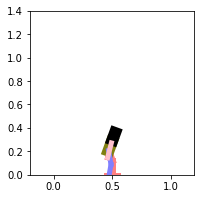

In [5]:

fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1,3,1)
ax.set_xlim((-0.2, 1.2))
ax.set_ylim((0, 1.4))
ax.set_aspect("equal")

robotQ = [ 90.0/180.0 * math.pi, 80.0/180.0 * math.pi, 
          20.0/180.0 * math.pi, 20.0/180.0 * math.pi, 
          -40.0/180.0 * math.pi, -30.0/180.0 * math.pi ]
frame, pos = drawRobot( ax, LEFT_LEG_SUPPORT, robotQ, [0.5,0], robotLinks )

[[0.3, 0.0], [0.3, 0.12], [0.2685341468140385, 0.2064517211123036], [0.29589575828009196, 0.28162713077517626], [0.2893719281340701, 0.08827479075083863], [0.27200711036737707, -0.010205984550382172]]
0.106


[0.21900711036737708, 0.106]

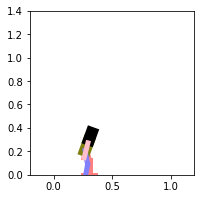

In [6]:

fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1,3,1)
ax.set_xlim((-0.2, 1.2))
ax.set_ylim((0, 1.4))
ax.set_aspect("equal")

current_angles = np.array([ 90.0/180.0 * math.pi, 80.0/180.0 * math.pi, 
          20.0/180.0 * math.pi, 20.0/180.0 * math.pi, 
          -40.0/180.0 * math.pi, -30.0/180.0 * math.pi])


pos = [0.3,0]

_, initial = drawRobot( ax, LEFT_LEG_SUPPORT, current_angles, pos, robotLinks )

print(initial)
lifoff = -1*(robotLinks[3]+ robotLinks[5])/4

stepheight = (robotLinks[3]+ robotLinks[5])/2

print(stepheight)

target = [sum(i) for i in zip(initial[-1],[lifoff,0])]

target = [target[0], stepheight]

target

Just one leg

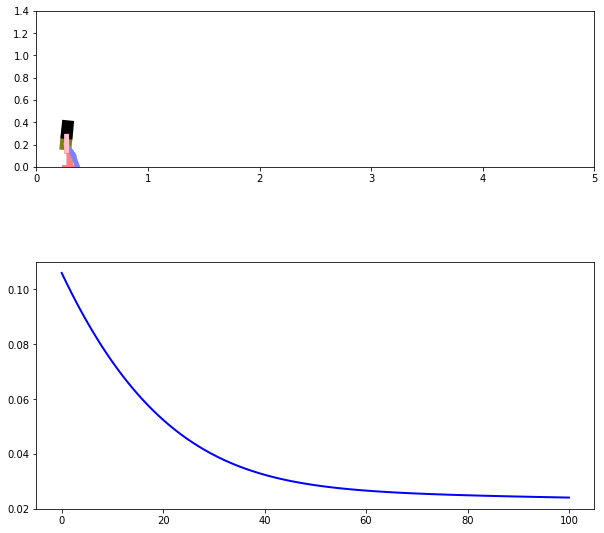

In [7]:
from matplotlib.animation import ArtistAnimation
import numpy as np


fig = plt.figure( figsize=(10,10) )
ax1 = fig.add_subplot(2,1,1)
ax1.set_xlim((0, 5))
ax1.set_ylim((0, 1.4))
ax1.set_aspect("equal")

current_angles = np.array([ 90.0/180.0 * math.pi, 80.0/180.0 * math.pi, 
          20.0/180.0 * math.pi, 20.0/180.0 * math.pi, 
          -40.0/180.0 * math.pi, -30.0/180.0 * math.pi])


pos = [0.3,0]

_, initial = drawRobot( ax, LEFT_LEG_SUPPORT, current_angles, pos, robotLinks )

stepheight = 0

stepsize = (robotLinks[3]+ robotLinks[5])/2

target = [sum(i) for i in zip(initial[-1],[stepsize,stepheight])]

frames = []


def fwd_kinematics( thetas ):
  _, e = drawRobot( ax, LEFT_LEG_SUPPORT, thetas, pos, robotLinks )
  e = np.array(e[-1])
  return e

def Jacobian( thetas, fkin ):
  J = np.zeros( (2, len(thetas) ) )
  current_pos = fkin( thetas )
  dt = 1.0/180.0*math.pi    
  
  for i,t in enumerate(thetas):
    thetas_d = thetas.copy()
    thetas_d[i] = thetas_d[i] + dt
    p = fkin( thetas_d )
    x = ( p[0:2] - current_pos[0:2] ) / dt

    J[0:2,i] = ( p[0:2] - current_pos[0:2] ) / dt
  return J


current_position = np.array(pos)

target_position = np.array(target)


d_err = (target_position - current_position)[0:2]

alpha = 0.3

count = 0
errs = []

while( np.linalg.norm(d_err) > 0.001 ):

   # pos[0]=pos[0]+2*(positions[2][0] - positions[0][0])

    frame, positions  = drawRobot( ax1, LEFT_LEG_SUPPORT, current_angles, pos, robotLinks )
    current_position = np.array(positions[-1])
    d_err = (target_position - current_position)
    errs.append( np.linalg.norm(d_err) )

    jac = Jacobian(current_angles, fwd_kinematics)

    d_theta = jac.T.dot(d_err) 

    current_angles = current_angles + alpha * d_theta

    frames.append( frame  )

    count = count + 1
    if (count > 100 ):
        break


ax2 = fig.add_subplot(2,1,2)
ax2.plot(errs, "b-", linewidth=2)


ani = ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1000)

from IPython.display import HTML
display( HTML(ani.to_html5_video()) )



one step


[[0.3773732878179265, 0.0], [0.3982110691379582, 0.11817693036146495], [0.3848769861454255, 0.2092055095591447], [0.43405676068875493, 0.2723034475275703], [0.3536037443121769, 0.0933522215383071], [0.29744604212371273, 0.010609774844292999]]


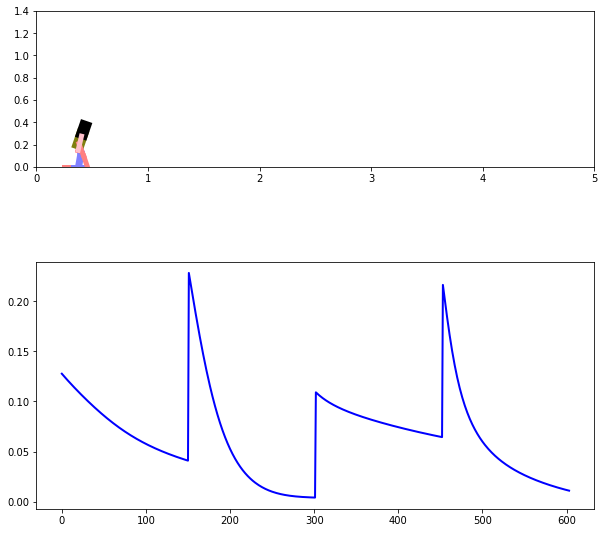

In [ ]:
from matplotlib.animation import ArtistAnimation
import numpy as np


fig = plt.figure( figsize=(10,10) )
ax1 = fig.add_subplot(2,1,1)
ax1.set_xlim((0, 5))
ax1.set_ylim((0, 1.4))
ax1.set_aspect("equal")


current_angles = np.array([ 90.0/180.0 * math.pi, 80.0/180.0 * math.pi, 
          20.0/180.0 * math.pi, 20.0/180.0 * math.pi, 
          -40.0/180.0 * math.pi, -30.0/180.0 * math.pi])


pos = [0.3,0]

_, initial = drawRobot( ax, LEFT_LEG_SUPPORT, current_angles, pos, robotLinks )

stepheight = 0

stepsize = (robotLinks[3]+ robotLinks[5])/2

target = [sum(i) for i in zip(initial[-1],[stepsize,stepheight])]

frames = []


def fwd_kinematics( thetas ):
  _, e = drawRobot( ax, LEFT_LEG_SUPPORT, thetas, pos, robotLinks )
  e = np.array(e[-1])
  return e

def Jacobian( thetas, fkin ):
  J = np.zeros( (2, len(thetas) ) )
  current_pos = fkin( thetas )
  dt = 1.0/180.0*math.pi    
  
  for i,t in enumerate(thetas):
    thetas_d = thetas.copy()
    thetas_d[i] = thetas_d[i] + dt
    p = fkin( thetas_d )
    x = ( p[0:2] - current_pos[0:2] ) / dt

    J[0:2,i] = ( p[0:2] - current_pos[0:2] ) / dt
  return J


current_position = np.array(pos)

target_position = np.array(target)


d_err = (target_position - current_position)[0:2]

alpha = 0.3

count = 0
errs = []

while( np.linalg.norm(d_err) > 0.001 ):

    frame, positions  = drawRobot( ax1, LEFT_LEG_SUPPORT, current_angles, pos, robotLinks )
    current_position = np.array(positions[-1])
    d_err = (target_position - current_position)
    errs.append( np.linalg.norm(d_err) )

    jac = Jacobian(current_angles, fwd_kinematics)

    d_theta = jac.T.dot(d_err) 

    current_angles = current_angles + alpha * d_theta

    frames.append( frame  )

    count = count + 1
    if (count > 150 ):
        break
        

pos[0]=pos[0]+2*(positions[2][0] - positions[0][0])


_, initial = drawRobot( ax, RIGHT_LEG_SUPPORT, current_angles, pos, robotLinks )


stepheight = 0

stepsize = (robotLinks[3]+ robotLinks[5])/2

target = [sum(i) for i in zip(initial[-1],[stepsize,stepheight])]


current_position = np.array(pos)

target_position = np.array(target)

d_err = (target_position - current_position)[0:2]

count = 0


while( np.linalg.norm(d_err) > 0.001 ):


    frame, positions  = drawRobot( ax1, RIGHT_LEG_SUPPORT, current_angles, pos, robotLinks )
    current_position = np.array(positions[-1])
    d_err = (target_position - current_position)
    errs.append( np.linalg.norm(d_err) )

    jac = Jacobian(current_angles, fwd_kinematics)

    d_theta = jac.T.dot(d_err) 

    current_angles = current_angles - alpha * d_theta

    frames.append( frame  )

    count = count + 1
    if (count > 150 ):
        break
        

ax2 = fig.add_subplot(2,1,2)
ax2.plot(errs, "b-", linewidth=2)


ani = ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1000)

from IPython.display import HTML
display( HTML(ani.to_html5_video()) )

